In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
!ls "/content/drive/My Drive/Comp 550 NLP/financial_sentiment_data.csv"

Mounted at /content/drive/
'/content/drive/My Drive/Comp 550 NLP/financial_sentiment_data.csv'


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
import nltk
from nltk.corpus import stopwords
import pandas as pd
import csv
import torch


In [ ]:

df = pd.read_csv("/content/drive/My Drive/Comp 550 NLP/financial_sentiment_data.csv")
df.head()

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


# Load and preprocess data

In [ ]:
# Specify the path to your CSV file
csv_file_path = "/content/drive/My Drive/Comp 550 NLP/financial_sentiment_data.csv"

# Create empty lists for each column
categories = []
texts = []

category_to_encoding = {
    "negative": 0,
    "neutral": 1,
    "positive": 2
}

# Open the CSV file and read its contents
with open(csv_file_path, 'r') as csv_file:
    # Create a CSV reader object
    csv_reader = csv.DictReader(csv_file)

    for row in csv_reader:
        categories.append(category_to_encoding[row["sentiment"]])
        texts.append(row["text"])

print(texts)
print(categories)

['According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .', 'Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .', 'The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported .', 'With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .', "According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales growth in the range of 20 % -40 % with an operating profit margin of 10 % -20 % of net sales .", "FINANCING OF ASPOCOMP 'S

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')  # Download the Punkt tokenizer data
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))

#stemmer = nltk.PorterStemmer()
lemmatizer = nltk.WordNetLemmatizer()

preprocessed_texts = [] # A list where each element is a string corresponding to the tokens after the stopwords and non-alnum tokens are removed for this fact
for text in texts:
  tokens = nltk.word_tokenize(text)
  new_tokens = []
  for word in tokens:
    if word.isalnum() and word.lower() not in stop_words:
      #stemmed_word = stemmer.stem(word.lower())
      lemmatized_word = lemmatizer.lemmatize(word.lower())
      new_tokens.append(lemmatized_word)
  preprocessed_texts.append(' '.join(new_tokens))

print(preprocessed_texts)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['according gran company plan move production russia although company growing', 'technopolis plan develop stage area le square meter order host company working computer technology telecommunication statement said', 'international electronic industry company elcoteq laid ten employee tallinn facility contrary earlier layoff company contracted rank office worker daily postimees reported', 'new production plant company would increase capacity meet expected increase demand would improve use raw material therefore increase production profitability', 'according company updated strategy year basware target net sale growth range 20 operating profit margin 10 net sale', 'financing aspocomp growth aspocomp aggressively pursuing growth strategy increasingly focusing technologically demanding hdi printed circuit board pcbs', 'last quarter 2010 componenta net sale doubled eur131m eur76m period year earlier moved zero profit loss eur7m', 'third quarter 2010 net sale increased eur mn operating profit

# Split the Dataset

In [ ]:
preprocessed_train_val_texts, preprocessed_test_texts, y_train_val, y_test = train_test_split(preprocessed_texts, categories, test_size=0.2, random_state=42)

preprocessed_train_texts, preprocessed_val_texts, y_train, y_val = train_test_split(preprocessed_train_val_texts, y_train_val, test_size=0.2, random_state=42)

print(preprocessed_train_texts)
print(y_train)


['2008 avc systemhaus net sale eur 10 million usd', 'device offer multimedia performance along host productivity application including live stock price', 'chuck smith laid may 30 housing consultant job wife cut spending half family six rely wife income alone', 'suomen paikallissanomat oy part alma medium group currently publishes 15 local newspaper across finland', 'service fesco telling example strengthening relationship logistics company operator international level', 'however total order received still last year level', 'adjustment measure carried phase secure delivery capability', 'biggest seller chain supermarket finland organic pirkka tomato carrot egg meat product', 'based 2005 calendar year combined company eur15 bn pro forma annual revenue expected start operation employee', 'route helsinki finland tallinn estonia cargo volume increased 36 cargo volume finland sweden fell 9', 'technology become available business fourth quarter nokia said', 'bond value eur150m maturity 4 year'

# Tokenize data for BERT

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the input texts
tokenized_train_texts = tokenizer(preprocessed_train_texts, padding=True, truncation=True, return_tensors='pt')
tokenized_val_texts = tokenizer(preprocessed_val_texts, padding=True, truncation=True, return_tensors='pt')
tokenized_test_texts = tokenizer(preprocessed_test_texts, padding=True, truncation=True, return_tensors='pt')

# Create PyTorch DataLoader
train_dataset = TensorDataset(tokenized_train_texts['input_ids'], tokenized_train_texts['attention_mask'], torch.tensor(y_train))
val_dataset = TensorDataset(tokenized_val_texts['input_ids'], tokenized_val_texts['attention_mask'], torch.tensor(y_val))
test_dataset = TensorDataset(tokenized_test_texts['input_ids'], tokenized_test_texts['attention_mask'], torch.tensor(y_test))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


# Hyperparameter Tuning

In [ ]:
# Hyperparameters
learning_rates = [2e-5, 1e-4, 1e-3, 1e-2]
batch_sizes = [16, 32, 64, 100]
epochs = 7

lr_accuracies = []
bs_accuracies = []

## Experiment 1: Vary learning rate, Fixed batch size

In [ ]:
from transformers import get_linear_schedule_with_warmup

for lr in learning_rates:
  # Load pre-trained BERT model for sequence classification
  bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

  # Set up optimizer and learning rate scheduler
  optimizer = torch.optim.Adam(bert_model.parameters(), lr=lr)
  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader)*epochs)

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  bert_model.to(device)

  # Fine-tune the BERT model
  for epoch in range(epochs):
      bert_model.train()
      for batch in train_loader:
          input_ids, attention_mask, label = batch
          input_ids, attention_mask, label = input_ids.to(device), attention_mask.to(device), label.to(device)

          # Clear previous gradients
          optimizer.zero_grad()

          # Forward pass
          outputs = bert_model(input_ids, attention_mask=attention_mask, labels=label)

          loss = outputs.loss

          # Backward pass and optimization
          loss.backward()

          optimizer.step()
          scheduler.step()

  # Evaluate model on validation set
  bert_model.eval()
  yh = []

  for batch in val_loader:
      input_ids, attention_mask, labels = batch
      input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

      with torch.no_grad():
          outputs = bert_model(input_ids, attention_mask=attention_mask)

      logits = outputs.logits
      preds = torch.argmax(logits, dim=1)

      yh.extend(preds.cpu().numpy())

  # Calculate accuracy on the test set
  accuracy = accuracy_score(y_val, yh)
  lr_accuracies.append(accuracy)



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are

Validation Accuracy for learning rate 2e-05: 0.73
Validation Accuracy for learning rate 0.0001: 0.71
Validation Accuracy for learning rate 0.001: 0.6
Validation Accuracy for learning rate 0.01: 0.6



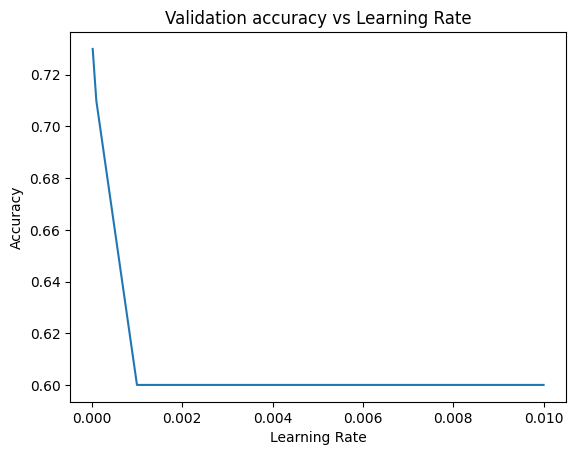

In [ ]:
import matplotlib.pyplot as plt

for lr, acc in zip(learning_rates, lr_accuracies):
  acc = round(acc, 2)
  print(f"Validation Accuracy for learning rate {lr}: {acc}")

print()
# Plotting the line graph
plt.plot(learning_rates, lr_accuracies)

# Adding labels and title
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Validation accuracy vs Learning Rate')

# Save the plot as a PNG image
plt.savefig('plot1.png')

# Display the plot
plt.show()


2e-5 produced the best accuracy on the validation set.

In [ ]:
lr = 2e-5

## Experiment 2: Vary batch size, Fixed learning rate

In [ ]:
for batch_size in batch_sizes:
  # Create data loaders for training and validation sets
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

  # Load pre-trained BERT model for sequence classification
  bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

  # Set up optimizer and learning rate scheduler
  optimizer = torch.optim.Adam(bert_model.parameters(), lr=lr)
  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader)*epochs)

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  bert_model.to(device)

  # Fine-tune the BERT model
  for epoch in range(epochs):
      bert_model.train()
      for batch in train_loader:
          input_ids, attention_mask, label = batch
          input_ids, attention_mask, label = input_ids.to(device), attention_mask.to(device), label.to(device)

          # Clear previous gradients
          optimizer.zero_grad()

          # Forward pass
          outputs = bert_model(input_ids, attention_mask=attention_mask, labels=label)

          loss = outputs.loss

          # Backward pass and optimization
          loss.backward()

          optimizer.step()
          scheduler.step()

  # Evaluate model on validation set
  bert_model.eval()
  yh = []

  for batch in val_loader:
      input_ids, attention_mask, labels = batch
      input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

      with torch.no_grad():
          outputs = bert_model(input_ids, attention_mask=attention_mask)

      logits = outputs.logits
      preds = torch.argmax(logits, dim=1)

      yh.extend(preds.cpu().numpy())

  # Calculate accuracy on the test set
  accuracy = accuracy_score(y_val, yh)
  bs_accuracies.append(accuracy)
  print()
  print(f"Validation Accuracy for batch size {batch_size}: {accuracy}")
  print()



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Validation Accuracy for batch size 16: 0.6005154639175257



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Validation Accuracy for batch size 32: 0.6005154639175257



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Validation Accuracy for batch size 64: 0.6005154639175257



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Validation Accuracy for batch size 100: 0.6005154639175257



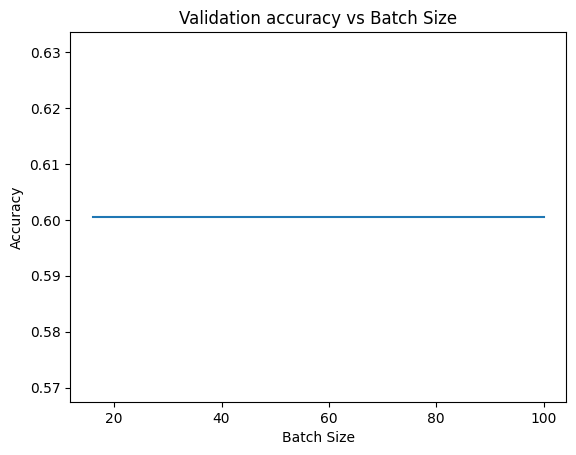

In [ ]:
# Plotting the line graph
plt.plot(batch_sizes, bs_accuracies)

# Adding labels and title
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.title('Validation accuracy vs Batch Size')

# Save the plot as a PNG image
plt.savefig('plot2.png')

# Display the plot
plt.show()


Batch size did not seem to have much of an effect on the validation accuracy so we'll choose batch size of 16.

In [ ]:
batch_size = 16

# Combine train and validation sets

In [ ]:
#preprocessed_train_texts, preprocessed_test_texts, y_train, y_test = train_test_split(preprocessed_texts, categories, test_size=0.2, random_state=42)

# Tokenize the input texts
tokenized_train_texts = tokenizer(preprocessed_train_val_texts, padding=True, truncation=True, return_tensors='pt')
tokenized_test_texts = tokenizer(preprocessed_test_texts, padding=True, truncation=True, return_tensors='pt')

# Create PyTorch DataLoader
train_dataset = TensorDataset(tokenized_train_texts['input_ids'], tokenized_train_texts['attention_mask'], torch.tensor(y_train_val))
test_dataset = TensorDataset(tokenized_test_texts['input_ids'], tokenized_test_texts['attention_mask'], torch.tensor(y_test))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Fine-tuned BERT model with best hyperparameters found

In [ ]:
# Load pre-trained BERT model for sequence classification
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Set up optimizer and learning rate scheduler
optimizer = torch.optim.Adam(bert_model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader)*epochs)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)

# Fine-tune the BERT model
for epoch in range(epochs):
    bert_model.train()
    for batch in train_loader:
        input_ids, attention_mask, label = batch
        input_ids, attention_mask, label = input_ids.to(device), attention_mask.to(device), label.to(device)

        # Clear previous gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = bert_model(input_ids, attention_mask=attention_mask, labels=label)

        loss = outputs.loss

        # Backward pass and optimization
        loss.backward()

        optimizer.step()
        scheduler.step()



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Evaluation on the test set
bert_model.eval()
all_preds = []

for batch in test_loader:
    input_ids, attention_mask, labels = batch
    input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

    with torch.no_grad():
        outputs = bert_model(input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    preds = torch.argmax(logits, dim=1)

    all_preds.extend(preds.cpu().numpy())

# Calculate accuracy on the test set
accuracy = accuracy_score(y_test, all_preds)
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.8257731958762886
